<div align="center"><h1>HPC / SENAI / Hackathon (2023.2)<br>
Laplacian Filter </h1></div>

**Murilo Boratto**$^1$

$^1$ Supercomputing Center SENAI CIMATEC, Salvador, Bahia, Brazil 

## Introdução

As técnicas de paralelismo compreendem em aplicação de estratégias baseadas na utilização de processamento paralelo manipulando diferentes recursos computacionais. Alguma dessas técnicas compreendem a utilização de bibliotecas paralelas como `OpenMP`, `MPI` e `CUDA`. Cada uma dessas bibliotecas consiste na manipulação de recursos computacionais diferentes, podendo ser utilizadas de forma híbrida a fim da obtenção de máximo desempenho. No OpenMP e CUDA manipulamos *Threads*, enquanto no MPI *Processos*, sendo de real relevância os impactos destas unidades de processamento frente aos recursos computacionais. A seguir será apresentado um código sequencial para a quebra de senha de até 20 caracteres utilizando um algoritmo de *Força Bruta*. O objetivo básico será inserir técnicas de paralelismo ao código, tal que serão considerados alguns itens nos produtos finais: 

* `Análise dos Custos Computacionais das Aplicações Sequênciais e Paralelas`
    + Profilling CPU (gprof)
    + Profiling GPU (nsys)
* `Estudo das Estruturas Algorítmicas das Aplicações Paralelas`
    + Modelos Algorítmicos Aplicados
    + Características da inserção da API
* `Análise de Desempenho`
     + Experimentação de Parâmetros Ótimos (Melhores valores de Processos, Threads e Grid Computacional)
     + Indices de eficiência (Speedup)

## Regras do Hackathon

* Os idiomas oficiais desse HPC Hackathon são: inglês e português;

* Este ano a competição será em grupos de 2 ou 3 pessoas;

* Tópico Principal: Portabilidade e Otimização de Código;
    
* Os participantes disponibilizarão os resultados através um repositório git pessoal que será configurado pelos participantes e/ou pela ferramenta GOOGLE COLAB;

* Além do código modificado, a resolução deve conter scripts de execução automática para obter os Parâmetros Ótimos e os Speedups;

* O código produzido será avaliado em 2 pontos: desempenho e speedup;

* Os participantes devem codificar e comentar seus códigos;

* Os participantes acessarão o supercomputador via ssh com suas contas previamente configuradas;

* As habilidades necessárias são: Git, C, C++, Python, Unix, shell, bash, OpenMP, CUDA, MPI;

Boa sorte e boa codificação!

## Detecção de Bordas de uma Imagem usando a Função Laplaciano

A detecção de bordas é uma técnica crucial em processamento de imagem e visão computacional para identificar os contornos de objetos dentro de uma imagem. Ela ajuda na segmentação de objetos, reconhecimento de padrões e outras operações que são a base para muitas aplicações em visão computacional.

Os filtros lineares são uma classe importante de filtros utilizados na detecção de bordas. Eles operam em cada pixel de uma imagem, aplicando uma matriz de pesos, conhecida como kernel, a uma vizinhança de pixels em torno do pixel de interesse. A operação linear é a convolução da matriz do kernel com os pixels da imagem. Com isso o Laplaciano de uma imagem é uma segunda derivada espacial que é usada para encontrar regiões da imagem onde há uma mudança rápida de intensidade. Em termos de detecção de bordas, isso corresponde às áreas onde os valores dos pixels estão mudando, o que normalmente ocorre nas bordas dos objetos.

O código a seguir em python, consegue simplificar o processo de detecção das bordas da imagem `lenna.png`:

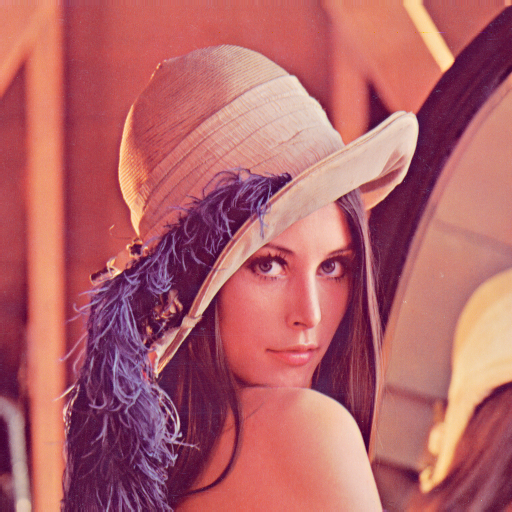

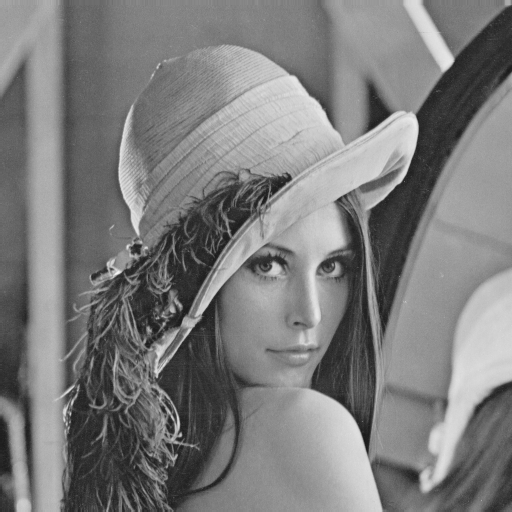

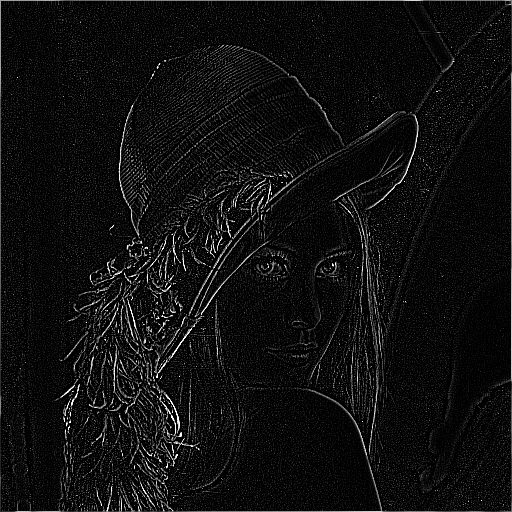

In [1]:
import numpy
from PIL import ImageFilter, Image as I
from IPython.display import display

# Opening the image (R prefixed to string
# in order to deal with '\' in paths)
path = "lenna.png"
image = I.open(path)
display(image)

# Converting the image to grayscale, as edge detection
# requires input image to be of mode = Grayscale (L)
img = image.convert("L")
display(img)

# Calculating Edges using the passed laplacian Kernel
final = img.filter(ImageFilter.Kernel((3, 3), (-1, -1, -1, -1, 8, -1, -1, -1, -1), 1, 0))
 
display(final)

### Algoritmo Sequencial 2D

In [20]:
%%writefile laplacian-2d-sequential.c
#include <stdio.h>
#include <stdlib.h>
#include <string.h>
#include <math.h>

void showMatrix(double *a, int n) {

   for (int i = 0; i < n; i++) {
      for (int j = 0; j < n; j++) {
        printf("%1.2f\t", a[i + j * n]);
      }
    printf("\n");
   }
   printf("\n");
}


void showVector(int *a, int n) {

   for (int i = 0; i < n; i++)
     printf("%d\t", a[i]);

   printf("\n\n");

}


void kernel(double *a, double *c,  int m, int n, int jsta2, int jend2, int dx, int dz) {

  double sx, sz;

  for (int j = jsta2 - 1; j < jend2; j++) {
     for (int i = 1; i < (m - 1); i++){
            sx = a[(i - 1) + j * n]  + a[(i + 1) + j * n]  + 2 * a[i + j * n];
            sz = a[i + (j - 1) * n]  + a[i + (j + 1) * n]  + 2 * a[i + j * n];
            c[i + j * n] = (sx/(dx*dx)) + (sz/(dz*dz));      
     }
      #ifdef PRINT
       showMatrix(c, n); 
      #endif
  }

}

void PARA_RANGE(int n1,int n2, int nprocs, int myid, int jsta, int jend, int *vector_return){

   int iwork1 = (n2 - n1 + 1) / nprocs;
   int iwork2 = (n2 - n1 + 1) % nprocs;

   jsta   = (myid * iwork1) + n1 + fmin((double)myid, (double)iwork2);
   jend   = jsta + iwork1 - 1;

   if (iwork2 > myid)
    jend = jend + 1;

   vector_return[0] = jsta;
   vector_return[1] = jend;

}

int main (int argc, char *argv[]) {
    
   int rows   = 8; 
   int column = rows;
   int myid;
   int nprocs;
   double dx, dz;
   double *a, *c;
   int jsta = 1, jend = 1, jsta2, jend2;
   int *vector_return = (int *) calloc (2, sizeof(int));
     
   a  =  (double*) calloc (rows * column, sizeof(double));
   c  =  (double*) calloc (rows * column, sizeof(double));

   dx = 1; dz = 1;

   myid = 0;
   nprocs = 1;

   PARA_RANGE(1, rows, nprocs, myid, jsta, jend, vector_return);

   jsta = vector_return[0];
   jend = vector_return[1];

   jsta2 = jsta;
   jend2 = jend;

   jsta2 = 2;         
   jend2 = column - 1;
    
   /*Population of the matrix*/
   for (int i = 0; i < rows; i++)
     for (int j = jsta - 1; j < jend; j++)
            a[i + j * rows] = (i + j + 2) * 1.;  /*stored dates in column (major column)*/

   showMatrix(a, rows);
       
   kernel(a, c, rows, column, jsta2, jend2, dx, dz);
   
   showMatrix(c, rows); 
       
   /*Free memories*/
   free(a);
   free(c);
     
   return 0;
}

Overwriting laplacian-2d-sequential.c


In [21]:
!gcc laplacian-2d-sequential.c -o laplacian-2d-sequential -O3

In [22]:
!./laplacian-2d-sequential

2.00	3.00	4.00	5.00	6.00	7.00	8.00	9.00	
3.00	4.00	5.00	6.00	7.00	8.00	9.00	10.00	
4.00	5.00	6.00	7.00	8.00	9.00	10.00	11.00	
5.00	6.00	7.00	8.00	9.00	10.00	11.00	12.00	
6.00	7.00	8.00	9.00	10.00	11.00	12.00	13.00	
7.00	8.00	9.00	10.00	11.00	12.00	13.00	14.00	
8.00	9.00	10.00	11.00	12.00	13.00	14.00	15.00	
9.00	10.00	11.00	12.00	13.00	14.00	15.00	16.00	

0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	
0.00	32.00	40.00	48.00	56.00	64.00	72.00	0.00	
0.00	40.00	48.00	56.00	64.00	72.00	80.00	0.00	
0.00	48.00	56.00	64.00	72.00	80.00	88.00	0.00	
0.00	56.00	64.00	72.00	80.00	88.00	96.00	0.00	
0.00	64.00	72.00	80.00	88.00	96.00	104.00	0.00	
0.00	72.00	80.00	88.00	96.00	104.00	112.00	0.00	
0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	



## Algoritmo Sequencial 2D de Validação

In [ ]:
%%writefile laplacian-2d-sequential.c
#include <stdio.h>
#include <stdlib.h>
#include <string.h>
#include <math.h>
#include <omp.h>

void showMatrix(double *a, int n) {

   for (int i = 0; i < n; i++) {
      for (int j = 0; j < n; j++) {
        printf("%1.2f\t", a[i + j * n]);
      }
    printf("\n");
   }
   printf("\n");
}


void showVector(int *a, int n) {

   for (int i = 0; i < n; i++)
     printf("%d\t", a[i]);

   printf("\n\n");

}


void kernel(double *a, double *c,  int m, int n, int jsta2, int jend2, int dx, int dz) {

  double sx, sz;

  for (int j = jsta2 - 1; j < jend2; j++) {
     for (int i = 1; i < (m - 1); i++){
            sx = a[(i - 1) + j * n]  + a[(i + 1) + j * n]  + 2 * a[i + j * n];
            sz = a[i + (j - 1) * n]  + a[i + (j + 1) * n]  + 2 * a[i + j * n];
            c[i + j * n] = (sx/(dx*dx)) + (sz/(dz*dz));      
     }
  }

}

void PARA_RANGE(int n1,int n2, int nprocs, int myid, int jsta, int jend, int *vector_return){

   int iwork1 = (n2 - n1 + 1) / nprocs;
   int iwork2 = (n2 - n1 + 1) % nprocs;

   jsta   = (myid * iwork1) + n1 + fmin((double)myid, (double)iwork2);
   jend   = jsta + iwork1 - 1;

   if (iwork2 > myid)
    jend = jend + 1;

   vector_return[0] = jsta;
   vector_return[1] = jend;

}

int main (int argc, char *argv[]) {
    
   int rows   = atoi(argv[1]); 
   int column = rows;
   int myid;
   int nprocs;
   double dx, dz;
   double *a, *c;
   int jsta = 1, jend = 1, jsta2, jend2;
   int *vector_return = (int *) calloc (2, sizeof(int));
     
   a  =  (double*) calloc (rows * column, sizeof(double));
   c  =  (double*) calloc (rows * column, sizeof(double));

   dx = 1; dz = 1;

   myid = 0;
   nprocs = 1;

   PARA_RANGE(1, rows, nprocs, myid, jsta, jend, vector_return);

   jsta = vector_return[0];
   jend = vector_return[1];

   jsta2 = jsta;
   jend2 = jend;

   jsta2 = 2;         
   jend2 = column - 1;
    
   /*Population of the matrix*/
   for (int i = 0; i < rows; i++)
     for (int j = jsta - 1; j < jend; j++)
            a[i + j * rows] = (i + j + 2) * 1.;  /*stored dates in column (major column)*/

   //showMatrix(a, rows);
       
   t1 = omp_get_wtime(); 
      kernel(a, c, rows, column, jsta2, jend2, dx, dz);
   t2 = omp_get_wtime();
    
   printf("%d\t%f\n",rows, t2-t1);
    
   //showMatrix(c, rows); 
       
   /*Free memories*/
   free(a);
   free(c);
     
   return 0;
}

In [ ]:
%%writefile script.sh
for((i = 64; i <= 1024; i+=64))
do
./$1 $i
done

In [ ]:
!gcc laplacian-2d-sequential.c -o laplacian-2d-sequential -O3

In [ ]:
!bash script.sh laplacian-2d-sequential

## Análise dos Custos Computacionais da Aplicação Sequencial (Profilling)

Conhecendo o algoritmo sequencial faz-se necessário mensurar os pontos do código que exigem maior custo computacional da aplicação,  para que possamos focar nossos esforços na paralelização desses trechos, desta maneira, conseguimos trabalhar de forma inteligente, onde o código realmente precisa ganhar desempenho. Para a realização dessa etapa, será utilizado uma ferramenta denominada GNU profiler (gprof) que faz parte do conjunto GNU Binary Utilities (binutils), que tem como principal funcionalidade analisar e capturar os tempos durante a execução do código, gerando relátorios de desempenho. 

Para executar o processo de profilling basta inserir o argumento _-pg_ na compilação do nosso código sequencial, executá-lo normalmente para gerar o arquivo binário do relatório e, logo depois, exibi-lo de forma legível através do comando associados ao gprof, ilustra-se a seguir: 

In [ ]:
!gcc laplacian-2d-sequential.c -o laplacian-2d-sequential -O3 -pg

In [ ]:
!./laplacian-2d-sequential 1024

In [ ]:
!gprof -b laplacian-2d-sequential gmon.out

<br>&emsp;Após a geração dos relatórios, podemos concluir estratégias de paralelismo para definir os próximos passos do processo de otimização. Pode-se observar que as funções _main_ e _my_pow_ não tem impacto significativo no tempo de execução do algoritmo, em contrapartida, a função _bruteforce_ é responsável por quase 100% do mesmo. Assim sendo, fica fácil de identificar os pontos de gargalo, partindo de um pressuposto que em um código, geralmente, o que mais consome tempo de execução são os laços e temos apenas três deles na função _bruteforce_.
<br> 
&emsp;Os dois primeiros laços são baseados no tamanho da string, enquanto o terceiro possue o maior custo computacional, pois nele será realizada a busca comparativa da chave.
<br>
&emsp;Para um viés de validação, posicionamos capturas de tempo antes e depois de cada laço, imprimindo no terminal o tempo de execução de cada um. Como esperado, os dois primeiros laços representam tempos insiginificantes, enquanto o laço de contagem consome a maior parte do tempo de execução do código. Com o estudo da execução do código realizado, estamos prontos para começar o processo de divisão do domínio e inserção de técnicas de paralelização ao código.

---
## Aplicações Paralelas

### Multicore (OPENMP)

In [ ]:
%%writefile laplacian-2d-omp.c

/**
TODO
*/

In [ ]:
!gcc laplacian-2d-omp.c -o laplacian-2d-omp -fopenmp -O3

In [ ]:
!OMP_NUM_THREADS=16 ./laplacian-2d-omp 1024

### Multiprocessor (MPI)

In [ ]:
%%writefile laplacian-2d-mpi.c

/**
TODO
*/

In [ ]:
!mpicc laplacian-2d-mpi.c -o laplacian-2d-mpi -fopenmp -O3

In [ ]:
!mpirun -np 4 ./laplacian-2d-mpi 1600

### Multiprocessor + Multicore (MPI + OpenMP)

In [ ]:
%%writefile laplacian-2d-mpi+omp.c

/**
TODO
*/

In [ ]:
!mpicc laplacian-2d-mpi+omp.c -olaplacian-2d-mpi+omp -fopenmp -O3

In [ ]:
!OMP_NUM_THREADS=4 mpirun -np 4 ./laplacian-2d-mpi+omp 1024

### GPU (CUDA)

In [ ]:
%%writefile laplacian-2d-1GPU.cu

/**
TODO
*/

In [ ]:
!nvcc laplacian-2d-1GPU.cu -o laplacian-2d-1GPU -O3

In [ ]:
!./laplacian-2d-1GPU 1024

## Análise Experimental

### I) Validação com Valores Pequenos

#### Parâmetros Ótimos de Execução

1. OpenMP = **A** Threads
2. MPI = **B** nós + **C** Processos
3. MPI + OpenMP = **D** nós + **E** Processos + **F** Threads
4. CUDA = G1D B1DT1D (**G** * 32, 1024)

### Tempos de execução em segundos das aplicações

|  Entradas    | Sequencial | OpenMP | MPI  | Híbrido | CUDA
| ---------------------| ---------- | ------ | ---  | ------- | ----
| 64        |            |        |      |         |  
| 256       |            |        |      |         | 
| 512       |            |        |      |         | 
| 1024      |            |        |      |         | 

### Speedups

|  Senha    |  OpenMP    | MPI     | Híbrido       | CUDA
| --------- |  ------    | ------  | -------       | ----
| 64        |            |        |      |         |  
| 256       |            |        |      |         | 
| 512       |            |        |      |         | 
| 1024      |            |        |      |         | 

### II) Análise de Desempenho - 1600

#### Parâmetros Ótimos de Execução

1. OpenMP = A Threads
2. MPI = B nós + C Processos
3. MPI + OpenMP = D nós + E Processos + F Threads
4. CUDA = G1D B1DT1D (G * 32, 1024)

### Tempo de execução em segundos das aplicações

|  Senha (Entradas)    | Sequencial | OpenMP | MPI  | Híbrido | CUDA
| ---------------------| ---------- | ------ | ---  | ------- | ----
| 1600                 |            |        |      |         |  


### Speedup

|  Senha    |  OpenMP    | MPI     | Híbrido       | CUDA
| --------- |  ------    | ------  | -------       | ----
| 1600   |            |         |               |  


## Conclusões

Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.

## Referências Biliográficas

* G. Coulouris, J. Dollimore, T. Kindberg, G.Blair. Distributed Systems: Concepts and Design, Fifth Edition, Pearson, 2011.

* S.Tanenbaum, M. Steen, Distributed Systems: Principles and Paradigms, Second Edition, Pearson, 2006.

* David A. Patterson and John L. Hennessy. Computer Organization and Design: The Hardware/Software Interface. Morgan Kaufmann, 5th Edition, 2013.

* An Introduction to Parallel Programming by Peter S. Pacheco. Morgan Kauffman.

* W. C. Barbosa, An introduction to distributed algorithms, MIT Press, 1997. N. Lynch, Distributed Algorithms, Mit Press, 1996 e Introduction to Distributed Algorithms, Gerard Tel, Cabribridge U. Press, 1994.